# AllLife Bank Credit Card Customer Segmentation

**Description**

**Context**

AllLife Bank wants to focus on its credit card customer base in the next financial year. They have been advised by their marketing research team, that the penetration in the market can be improved. Based on this input, the Marketing team proposes to run personalized campaigns to target new customers as well as upsell to existing customers. Another insight from the market research was that the customers perceive the support services of the back poorly. Based on this, the Operations team wants to upgrade the service delivery model, to ensure that customer queries are resolved faster. Head of Marketing and Head of Delivery both decide to reach out to the Data Science team for help

**Objective**

To identify different segments in the existing customer, based on their spending patterns as well as past interaction with the bank, using clustering algorithms, and provide recommendations to the bank on how to better market to and service these customers.

**Data Description**

The data provided is of various customers of a bank and their financial attributes like credit limit, the total number of credit cards the customer has, and different channels through which customers have contacted the bank for any queries (including visiting the bank, online and through a call center).

**Data Dictionary**
* Sl_No: Primary key of the records
* Customer Key: Customer identification number
* Average Credit Limit: Average credit limit of each customer for all credit cards
* Total credit cards: Total number of credit cards possessed by the customer
* Total visits bank: Total number of visits that customer made (yearly) personally to the bank
* Total visits online: Total number of visits or online logins made by the customer (yearly)
* Total calls made: Total number of calls made by the customer to the bank or its customer service department (yearly)




```
# This is formatted as code
```

## Loading the Dataset

In [5]:
import pandas as pd
import numpy as np

import matplotlib.pylab as plt
%matplotlib inline

import seaborn as sns
from sklearn.model_selection  import train_test_split
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score


from scipy.stats import zscore

#import sklearn.metrics

bank_customer_df = pd.read_excel("Credit+Card+Customer+Data.xlsx")
bank_customer_df.dtypes

Sl_No                  int64
Customer Key           int64
Avg_Credit_Limit       int64
Total_Credit_Cards     int64
Total_visits_bank      int64
Total_visits_online    int64
Total_calls_made       int64
dtype: object

In [6]:
bank_customer_df.shape

(660, 7)

In [7]:
bank_customer_df.head()


,Sl_No,Customer Key,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
0,1,87073,100000,2,1,1,0
1,2,38414,50000,3,0,10,9
2,3,17341,50000,7,1,3,4
3,4,40496,30000,5,1,1,4
4,5,47437,100000,6,0,12,3


In [8]:
df = bank_customer_df.copy()
# dropping the serial no. column as it does not provide any information
df.drop("Sl_No", axis=1, inplace=True)
df.drop("Customer Key", axis=1, inplace=True)


In [9]:
df.head()

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
0,100000,2,1,1,0
1,50000,3,0,10,9
2,50000,7,1,3,4
3,30000,5,1,1,4
4,100000,6,0,12,3


In [10]:
# viewing a random sample of the dataset
df.sample(n=10, random_state=1)

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
547,26000,4,5,2,4
353,9000,5,4,1,3
499,68000,6,4,2,2
173,9000,2,1,5,8
241,10000,4,5,1,3
341,18000,4,3,2,0
647,183000,9,0,9,2
218,19000,3,1,5,7
120,10000,4,2,4,6
134,13000,4,1,5,7


In [11]:
# let's look at the structure of the data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 660 entries, 0 to 659
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype
---  ------               --------------  -----
 0   Avg_Credit_Limit     660 non-null    int64
 1   Total_Credit_Cards   660 non-null    int64
 2   Total_visits_bank    660 non-null    int64
 3   Total_visits_online  660 non-null    int64
 4   Total_calls_made     660 non-null    int64
dtypes: int64(5)
memory usage: 25.9 KB


In [12]:
# let's check for duplicate observations
df.duplicated().sum()

11

In [13]:
df = df[(~df.duplicated())].copy()

There are 11 duplicate observations. We will remove them from the data.


Let's take a look at the summary of the data

In [14]:
df.describe()

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
count,649.000000,649.000000,649.000000,649.000000,649.000000
mean,34878.274268,4.708783,2.397535,2.624037,3.590139
std,37813.736638,2.173763,1.625148,2.952888,2.877911
min,3000.000000,1.000000,0.000000,0.000000,0.000000
25%,11000.000000,3.000000,1.000000,1.000000,1.000000
50%,18000.000000,5.000000,2.000000,2.000000,3.000000
75%,49000.000000,6.000000,4.000000,4.000000,5.000000
max,200000.000000,10.000000,5.000000,15.000000,10.000000


**Observations**

* The average avg_credit_limit is 34878.
* The average total_credit_cards is 4.
* The average total_visits_bank is 2.
* The average Total_visits_online is 2.
* The average number of total_calls_made is 3.

In [15]:
# checking missing values
df.isna().sum()

Avg_Credit_Limit       0
Total_Credit_Cards     0
Total_visits_bank      0
Total_visits_online    0
Total_calls_made       0
dtype: int64

There are no missing values in the data.


**EDA**

In [16]:
# function to plot a boxplot and a histogram along the same scale.


def histogram_boxplot(data, feature, figsize=(12, 7), kde=False, bins=None):
    """
    Boxplot and histogram combined

    data: dataframe
    feature: dataframe column
    figsize: size of figure (default (12,7))
    kde: whether to the show density curve (default False)
    bins: number of bins for histogram (default None)
    """
    f2, (ax_box2, ax_hist2) = plt.subplots(
        nrows=2,  # Number of rows of the subplot grid= 2
        sharex=True,  # x-axis will be shared among all subplots
        gridspec_kw={"height_ratios": (0.25, 0.75)},
        figsize=figsize,
    )  # creating the 2 subplots
    sns.boxplot(
        data=data, x=feature, ax=ax_box2, showmeans=True, color="violet"
    )  # boxplot will be created and a star will indicate the mean value of the column
    sns.histplot(
        data=data, x=feature, kde=kde, ax=ax_hist2, bins=bins, palette="winter"
    ) if bins else sns.histplot(
        data=data, x=feature, kde=kde, ax=ax_hist2
    )  # For histogram
    ax_hist2.axvline(
        data[feature].mean(), color="green", linestyle="--"
    )  # Add mean to the histogram
    ax_hist2.axvline(
        data[feature].median(), color="black", linestyle="-"
    )  # Add median to the histogram

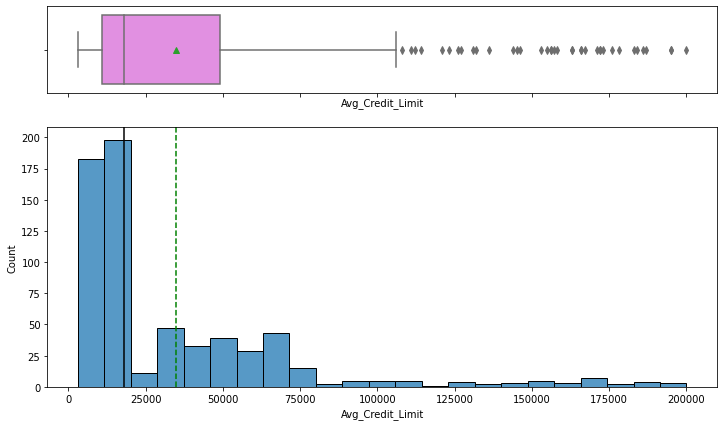

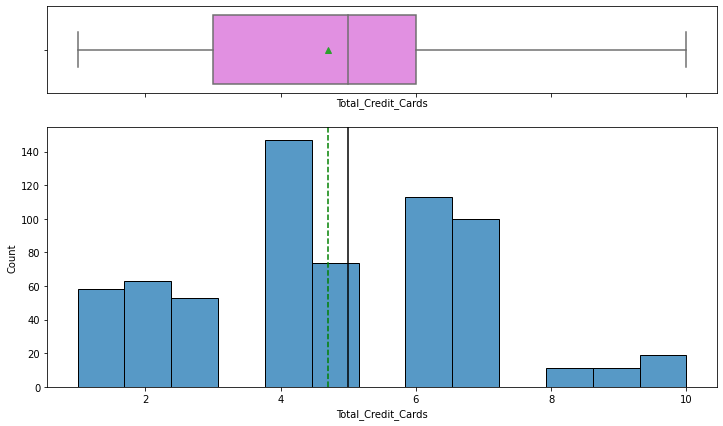

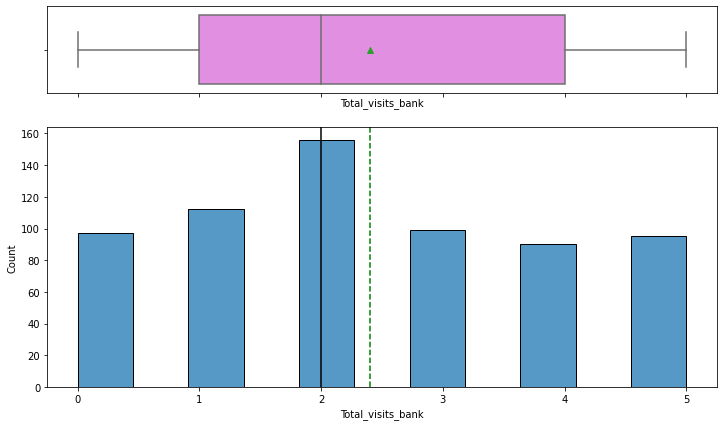

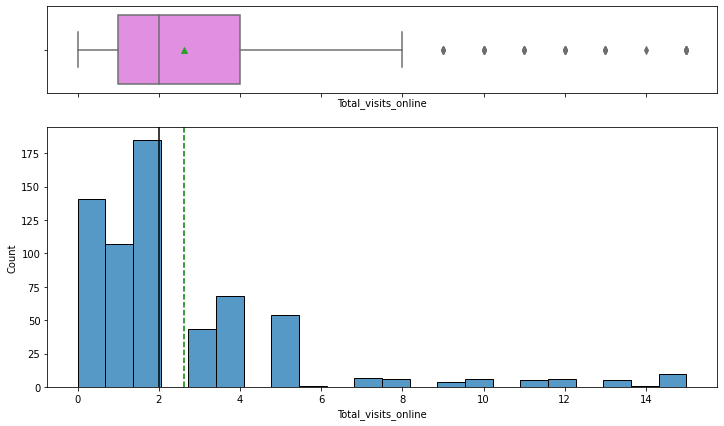

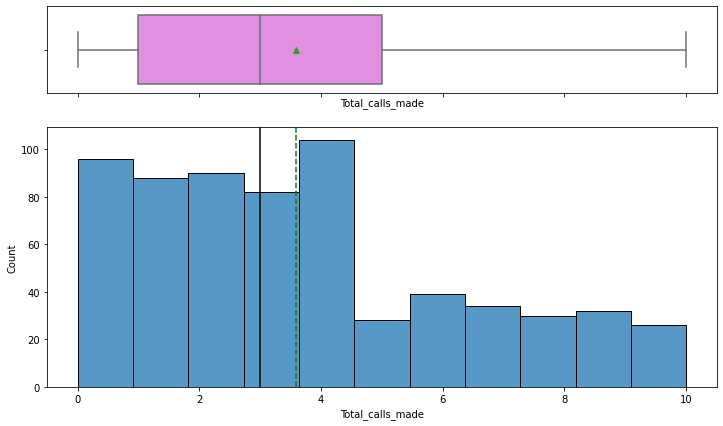

In [17]:
# selecting numerical columns
num_col = df.select_dtypes(include=np.number).columns.tolist()

for item in num_col:
    histogram_boxplot(df, item)

**Observations**

* Avg_Credit_Limit and Total_Visit_Online are right-skewed 
* distributions with upper outliers for avg_Credit_Limit and Total_Visits_online indicate presence of high credit limit and high no of online visits .
* The maximum no of credit cards is 10.
* The maximum value of Total calls made is 10.

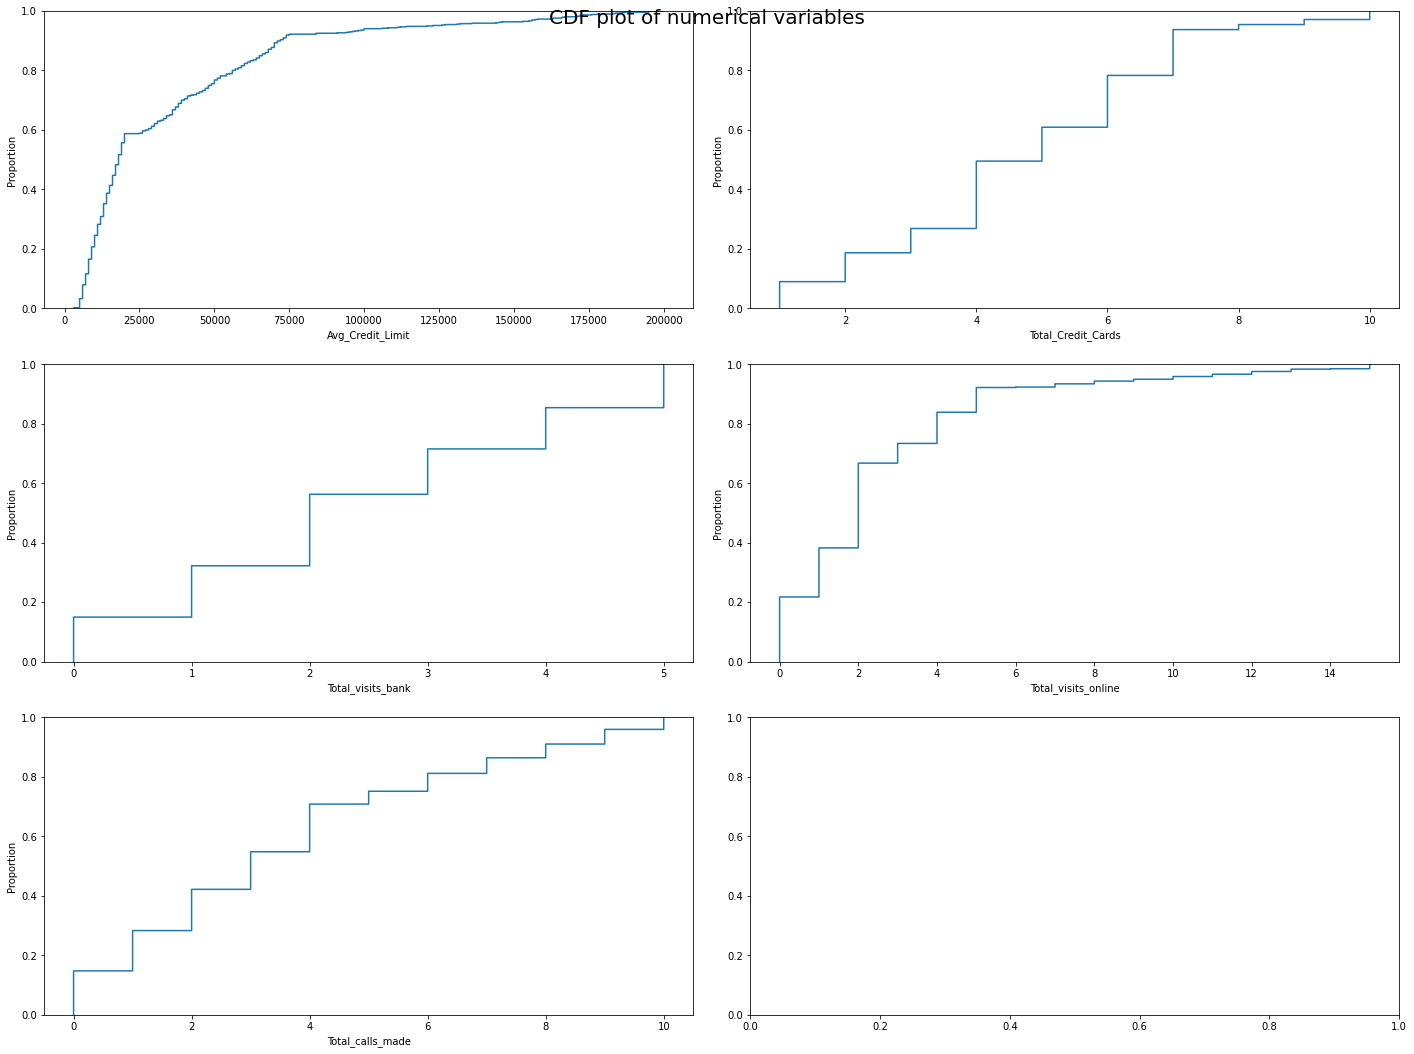

In [18]:
fig, axes = plt.subplots(3, 2, figsize=(20, 15))
fig.suptitle("CDF plot of numerical variables", fontsize=20)
counter = 0
for ii in range(3):
    sns.ecdfplot(ax=axes[ii][0], x=df[num_col[counter]])
    counter = counter + 1
    if counter != 5:
        sns.ecdfplot(ax=axes[ii][1], x=df[num_col[counter]])
        counter = counter + 1
    else:
        pass

fig.tight_layout(pad=2.0)


**Observations**

* 90% of the customers have  avg_credit_limit less than 75000.
* 80% of the customers have less than 6 credit cards.
* 80% of the customers visted bank less than 4 times.
* 50% off the products have a rating of 3.5 or less than 3.5.
* 100% customers make less than 10 calls.
* 80% customers online visit less than 6.


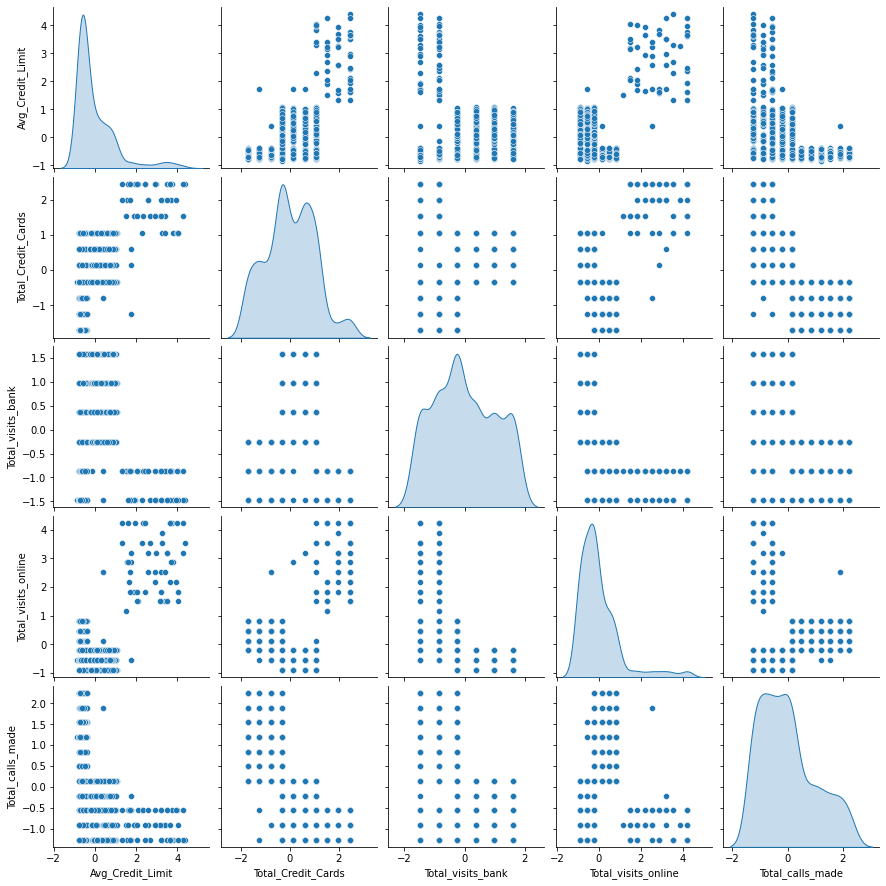

In [19]:
customerAttr=bank_customer_df.iloc[:,2:]
customerScaled=customerAttr.apply(zscore)
sns.pairplot(customerScaled,diag_kind='kde')

Avg credit limit is zero for many customers

**Let's check for correlations.**

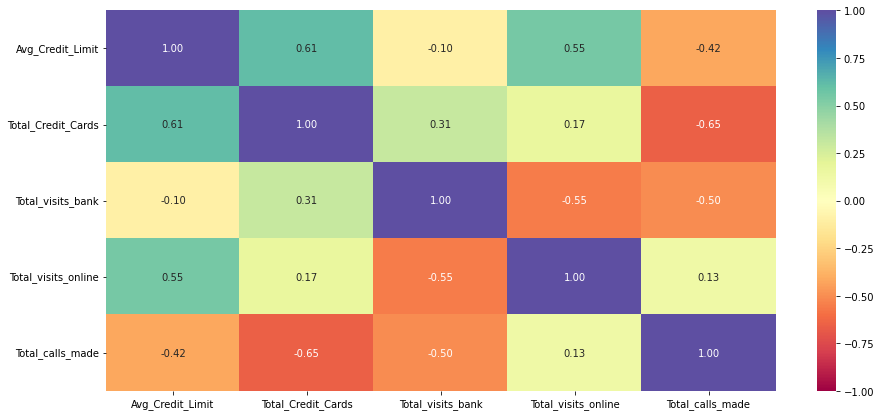

In [20]:
plt.figure(figsize=(15, 7))
sns.heatmap(df[num_col].corr(), annot=True, vmin=-1, vmax=1, fmt=".2f", cmap="Spectral")
plt.show()


**Observations**

* Avg_Credit_Limit and total credit cards are positively correlated.
* total visit online and avg credit limit also positively correlated.


## Group Data into similar clusters

Now, we will use K-Means clustering to group data based on their attribute. First, we need to determine the optimal number of groups. For that we conduct the knee test to see where the knee happens.

Text(0.5, 1.0, 'Selecting k with the Elbow Method')

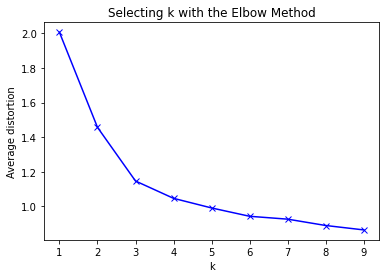

In [21]:
#Finding optimal no. of clusters
from scipy.spatial.distance import cdist
clusters=range(1,10)
meanDistortions=[]

for k in clusters:
    model=KMeans(n_clusters=k)
    model.fit(customerScaled)
    prediction=model.predict(customerScaled)
    meanDistortions.append(sum(np.min(cdist(customerScaled, model.cluster_centers_, 'euclidean'), axis=1)) / customerScaled.shape[0])


plt.plot(clusters, meanDistortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Average distortion')
plt.title('Selecting k with the Elbow Method')


**Let's check the silhouette scores.**

Though the bend is not coming out clearly as there are many bends, let us look at 3 clusters and 5 clusters

In [22]:
# Let us first start with K = 3
final_model=KMeans(3)
final_model.fit(customerScaled)
prediction=final_model.predict(customerScaled)

#Append the prediction 

bank_customer_df["GROUP"] = prediction
customerScaled["GROUP"] = prediction
print("Groups Assigned : \n")
bank_customer_df.head()

Groups Assigned : 



,Sl_No,Customer Key,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made,GROUP
0,1,87073,100000,2,1,1,0,0
1,2,38414,50000,3,0,10,9,1
2,3,17341,50000,7,1,3,4,0
3,4,40496,30000,5,1,1,4,0
4,5,47437,100000,6,0,12,3,2


In [23]:
from sklearn.cluster import KMeans


Number of Clusters: 1 	Average Distortion: 2.094337492922074
Number of Clusters: 2 	Average Distortion: 1.4919023124393709
Number of Clusters: 3 	Average Distortion: 1.1466276549150365
Number of Clusters: 4 	Average Distortion: 1.0471397905805744
Number of Clusters: 5 	Average Distortion: 0.9906725738045986
Number of Clusters: 6 	Average Distortion: 0.9429882588535909
Number of Clusters: 7 	Average Distortion: 0.9090837787089351
Number of Clusters: 8 	Average Distortion: 0.889334054749758


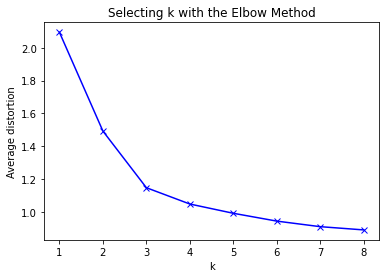

In [24]:
clusters = range(1, 9)
meanDistortions = []

for k in clusters:
    model = KMeans(n_clusters=k)
    model.fit(customerScaled)
    prediction = model.predict(customerScaled)
    distortion = (
        sum(
            np.min(cdist(customerScaled, model.cluster_centers_, "euclidean"), axis=1)
        )
        / customerScaled.shape[0]
    )

    meanDistortions.append(distortion)

    print("Number of Clusters:", k, "\tAverage Distortion:", distortion)

plt.plot(clusters, meanDistortions, "bx-")
plt.xlabel("k")
plt.ylabel("Average distortion")
plt.title("Selecting k with the Elbow Method")
plt.show()


For n_clusters = 2, the silhouette score is 0.43418833714796445)
For n_clusters = 3, the silhouette score is 0.5411228112448502)
For n_clusters = 4, the silhouette score is 0.36885590325418505)
For n_clusters = 5, the silhouette score is 0.27664876307197045)
For n_clusters = 6, the silhouette score is 0.2599776306630185)
For n_clusters = 7, the silhouette score is 0.2529913803120919)
For n_clusters = 8, the silhouette score is 0.22822475044071402)
For n_clusters = 9, the silhouette score is 0.21798551900667315)


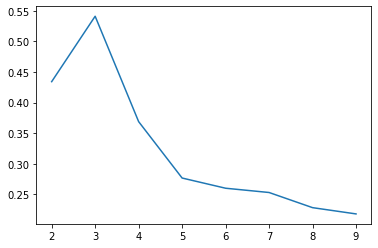

In [25]:
sil_score = []
cluster_list = list(range(2, 10))
for n_clusters in cluster_list:
    clusterer = KMeans(n_clusters=n_clusters)
    preds = clusterer.fit_predict((customerScaled))
    # centers = clusterer.cluster_centers_
    score = silhouette_score(customerScaled, preds)
    sil_score.append(score)
    print("For n_clusters = {}, the silhouette score is {})".format(n_clusters, score))

plt.plot(cluster_list, sil_score)
plt.show()

### Analyze the distribution of the data among the two groups (K = 3). One of the most informative visual tool is boxplot.


In [26]:
bankCreditCust = bank_customer_df.groupby(['GROUP'])
bankCreditCust.mean()

,Sl_No,Customer Key,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
GROUP,,,,,,,
0,417.528497,54881.329016,33782.383420,5.515544,3.489637,0.981865,2.000000
1,117.857143,55239.830357,12174.107143,2.410714,0.933036,3.553571,6.870536
2,611.280000,56708.760000,141040.000000,8.740000,0.600000,10.900000,1.080000


In [28]:
# adding kmeans cluster labels to the original and scaled dataframes

bank_customer_df["K_means_segments"] = final_model.labels_
customerScaled["K_means_segments"] = final_model.labels_

In [29]:
# function to plot a boxplot and a histogram along the same scale.


def histogram_boxplot(data, feature, figsize=(12, 7), kde=False, bins=None):
    """
    Boxplot and histogram combined

    data: dataframe
    feature: dataframe column
    figsize: size of figure (default (12,7))
    kde: whether to the show density curve (default False)
    bins: number of bins for histogram (default None)
    """
    f2, (ax_box2, ax_hist2) = plt.subplots(
        nrows=2,  # Number of rows of the subplot grid= 2
        sharex=True,  # x-axis will be shared among all subplots
        gridspec_kw={"height_ratios": (0.25, 0.75)},
        figsize=figsize,
    )  # creating the 2 subplots
    sns.boxplot(
        data=data, x=feature, ax=ax_box2, showmeans=True, color="violet"
    )  # boxplot will be created and a star will indicate the mean value of the column
    sns.histplot(
        data=data, x=feature, kde=kde, ax=ax_hist2, bins=bins, palette="winter"
    ) if bins else sns.histplot(
        data=data, x=feature, kde=kde, ax=ax_hist2
    )  # For histogram
    ax_hist2.axvline(
        data[feature].mean(), color="green", linestyle="--"
    )  # Add mean to the histogram
    ax_hist2.axvline(
        data[feature].median(), color="black", linestyle="-"
    )  # Add median to the histogram


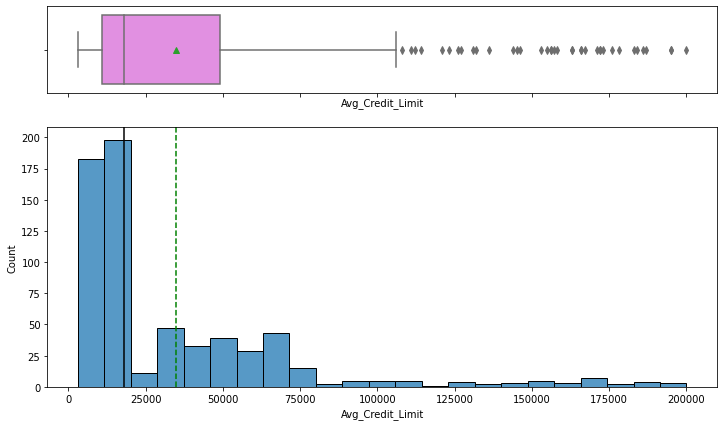

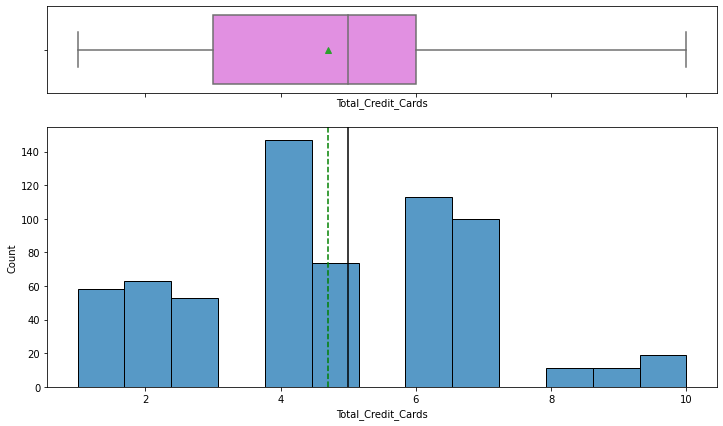

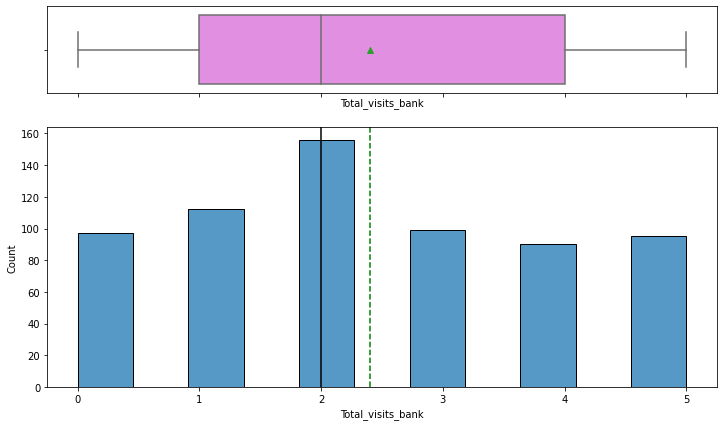

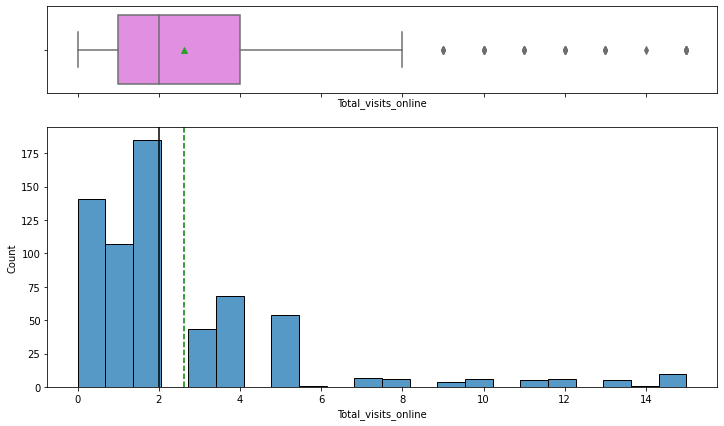

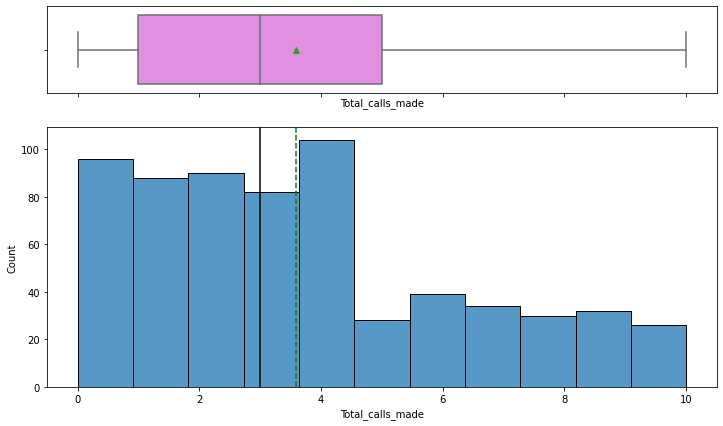

In [30]:
# selecting numerical columns
num_col = df.select_dtypes(include=np.number).columns.tolist()

for item in num_col:
    histogram_boxplot(df, item)

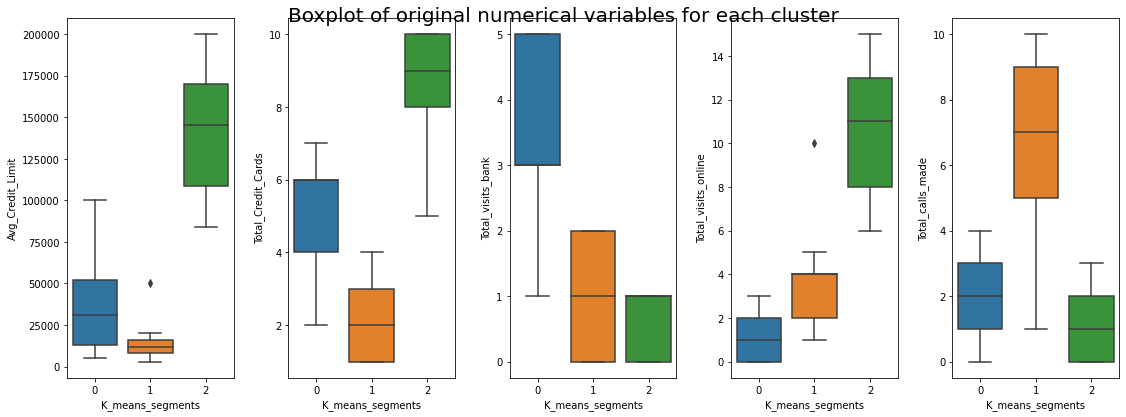

In [31]:
fig, axes = plt.subplots(1, 5, figsize=(16, 6))
fig.suptitle("Boxplot of original numerical variables for each cluster", fontsize=20)
counter = 0
for ii in range(5):
    sns.boxplot(ax=axes[ii], y=bank_customer_df[num_col[counter]], x=bank_customer_df["K_means_segments"])
    counter = counter + 1

fig.tight_layout(pad=2.0)

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))
/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))
/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tupl

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f447f087510>,
      dtype=object)

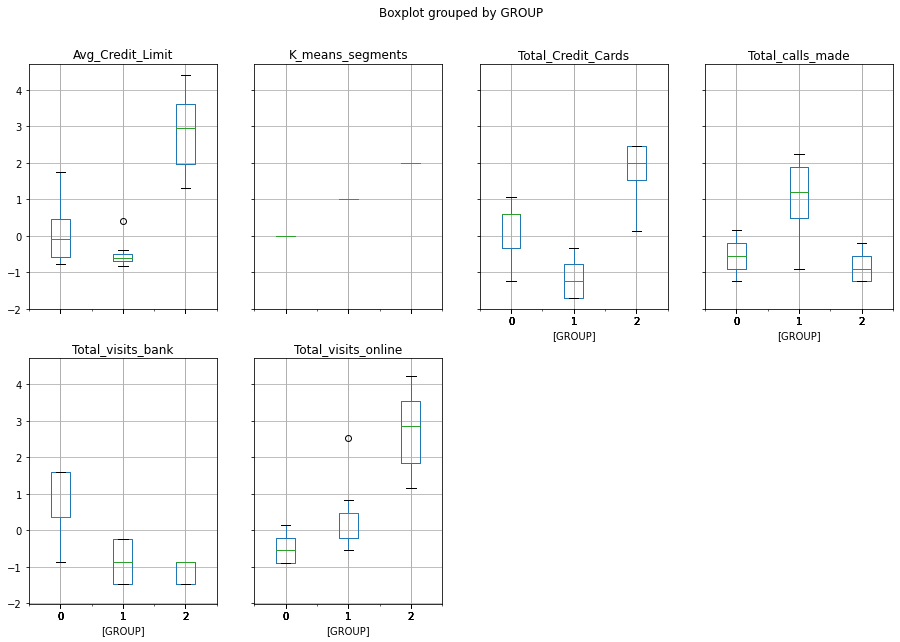

In [32]:
customerScaled.boxplot(by='GROUP', layout = (2,4),figsize=(15,10))

**Cluster Profiling**


In [33]:
cluster_profile = bank_customer_df.groupby("K_means_segments").mean()

In [34]:
cluster_profile["count_in_each_segments"] = (
    bank_customer_df.groupby("K_means_segments")["Avg_Credit_Limit"].count().values
)

In [35]:

# let's display cluster profiles
cluster_profile.style.highlight_max(color="lightgreen", axis=0)

,Sl_No,Customer Key,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made,GROUP,count_in_each_segments
K_means_segments,,,,,,,,,
0,417.528497,54881.329016,33782.383420,5.515544,3.489637,0.981865,2.000000,0.000000,386
1,117.857143,55239.830357,12174.107143,2.410714,0.933036,3.553571,6.870536,1.000000,224
2,611.280000,56708.760000,141040.000000,8.740000,0.600000,10.900000,1.080000,2.000000,50


In [36]:
df

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
0,100000,2,1,1,0
1,50000,3,0,10,9
2,50000,7,1,3,4
3,30000,5,1,1,4
4,100000,6,0,12,3
...,...,...,...,...,...
655,99000,10,1,10,0
656,84000,10,1,13,2
657,145000,8,1,9,1
658,172000,10,1,15,0


In [37]:
#  Let us next try with K = 5, the next elbow point

In [38]:
# Let us first start with K = 5
final_model=KMeans(5)
final_model.fit(customerScaled)
prediction=final_model.predict(customerScaled)

#Append the prediction 
bank_customer_df["GROUP"] = prediction
customerScaled["GROUP"] = prediction
print("Groups Assigned : \n")
bank_customer_df.head()

Groups Assigned : 



,Sl_No,Customer Key,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made,GROUP,K_means_segments
0,1,87073,100000,2,1,1,0,1,0
1,2,38414,50000,3,0,10,9,4,1
2,3,17341,50000,7,1,3,4,1,0
3,4,40496,30000,5,1,1,4,1,0
4,5,47437,100000,6,0,12,3,2,2


In [39]:
creditCardClust = bank_customer_df.groupby(['GROUP'])
creditCardClust.mean()

,Sl_No,Customer Key,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made,K_means_segments
GROUP,,,,,,,,
0,112.460870,53922.147826,11826.086957,2.434783,1.052174,3.339130,5.252174,1.0
1,419.627551,54073.484694,36260.204082,5.551020,2.494898,0.954082,2.061224,0.0
2,611.280000,56708.760000,141040.000000,8.740000,0.600000,10.900000,1.080000,2.0
3,415.363158,55714.684211,31226.315789,5.478947,4.515789,1.010526,1.936842,0.0
4,123.550459,56630.045872,12541.284404,2.385321,0.807339,3.779817,8.577982,1.0


/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))
/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))
/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tupl

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f4485fb74d0>,
      dtype=object)

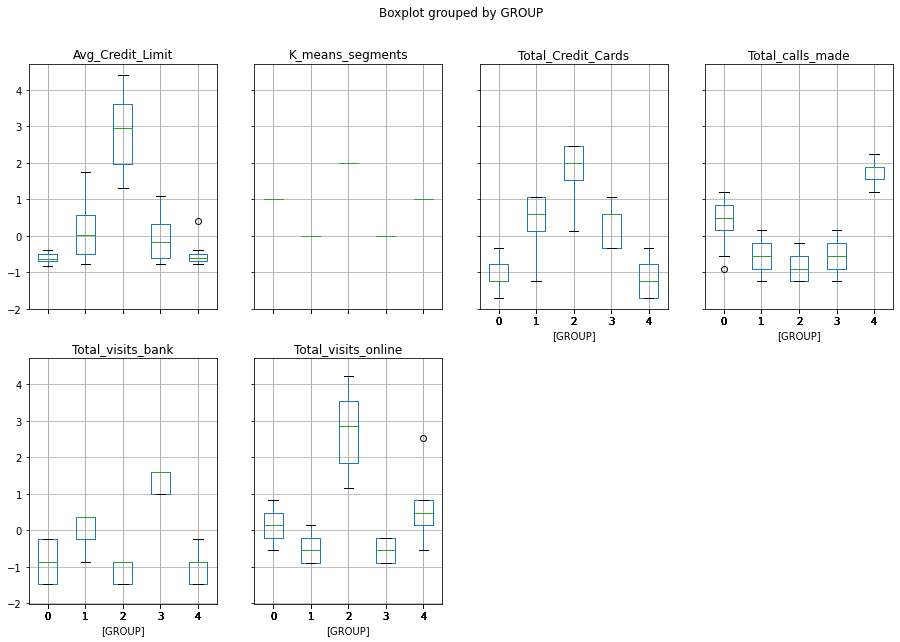

In [40]:
customerScaled.boxplot(by='GROUP', layout = (2,4),figsize=(15,10))

## Hierarchical Clustering


In [41]:
from sklearn.cluster import AgglomerativeClustering 

In [42]:
model = AgglomerativeClustering(n_clusters=3, affinity='euclidean',  linkage='average')

In [43]:
model.fit(customerScaled)

AgglomerativeClustering(linkage='average', n_clusters=3)

In [44]:
customerAttr['labels'] = model.labels_
customerAttr.head(10)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made,labels
0,100000,2,1,1,0,0
1,50000,3,0,10,9,2
2,50000,7,1,3,4,0
3,30000,5,1,1,4,0
4,100000,6,0,12,3,1
5,20000,3,0,1,8,2
6,100000,5,0,11,2,1
7,15000,3,0,1,1,0
8,5000,2,0,2,2,0
9,3000,4,0,1,7,0


In [45]:
custDataClust = customerAttr.groupby(['labels'])

In [46]:
custDataClust.mean()

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
labels,,,,,
0,28742.514970,4.808383,2.930140,1.522954,2.746507
1,141040.000000,8.740000,0.600000,10.900000,1.080000
2,12541.284404,2.385321,0.807339,3.779817,8.577982


In [47]:
from scipy.cluster.hierarchy import cophenet, dendrogram, linkage

In [48]:
from scipy.spatial.distance import pdist  #Pairwise distribution between data points

In [49]:
# cophenet index is a measure of the correlation between the distance of points in feature space and distance on dendrogram
# closer it is to 1, the better is the clustering

Z = linkage(customerScaled, metric='euclidean', method='average')
c, coph_dists = cophenet(Z , pdist(customerScaled))

c

0.9232101568299421

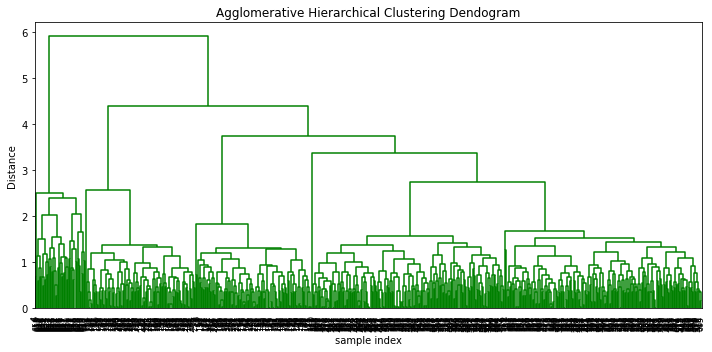

In [50]:
plt.figure(figsize=(10, 5))
plt.title('Agglomerative Hierarchical Clustering Dendogram')
plt.xlabel('sample index')
plt.ylabel('Distance')
dendrogram(Z, leaf_rotation=90.,color_threshold = 40, leaf_font_size=8. )
plt.tight_layout()

In [51]:
# cophenet index is a measure of the correlation between the distance of points in feature space and distance on dendrogram
# closer it is to 1, the better is the clustering

Z = linkage(customerScaled, metric='euclidean', method='complete')
c, coph_dists = cophenet(Z , pdist(customerScaled))

c

0.8809644566922354

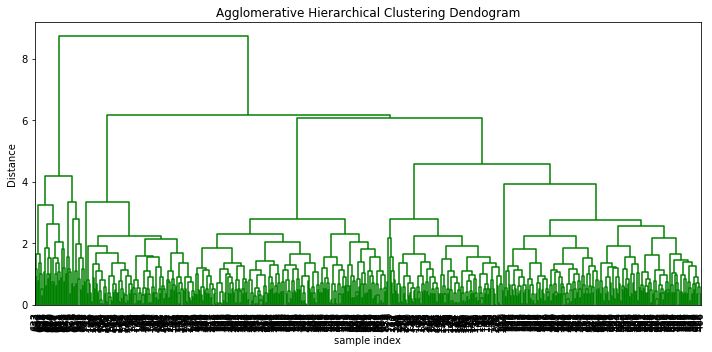

In [52]:
plt.figure(figsize=(10, 5))
plt.title('Agglomerative Hierarchical Clustering Dendogram')
plt.xlabel('sample index')
plt.ylabel('Distance')
dendrogram(Z, leaf_rotation=90.,color_threshold=90,  leaf_font_size=10. )
plt.tight_layout()

In [53]:
# cophenet index is a measure of the correlation between the distance of points in feature space and distance on dendrogram
# closer it is to 1, the better is the clustering

Z = linkage(customerScaled, metric='euclidean', method='ward')
c, coph_dists = cophenet(Z , pdist(customerScaled))

c

0.8095502287194011

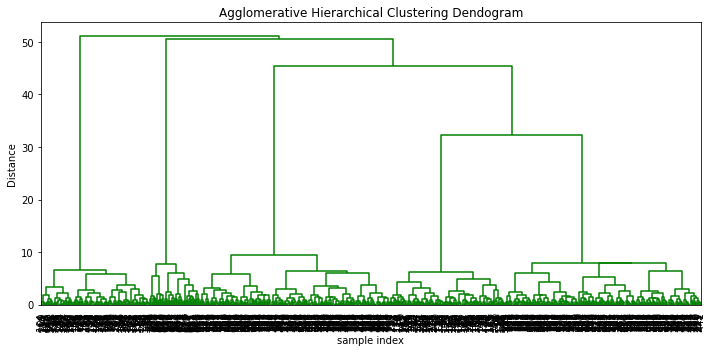

In [54]:
plt.figure(figsize=(10, 5))
plt.title('Agglomerative Hierarchical Clustering Dendogram')
plt.xlabel('sample index')
plt.ylabel('Distance')
dendrogram(Z, leaf_rotation=90.,color_threshold=600,  leaf_font_size=10. )
plt.tight_layout()

**K-means vs Hierarchical Clustering**

Cluster 0:
* Total visits online is highest for both K means and hierarchical clustering.
* credit card avg credit limit and total credit cards is highest

Cluster 1:

* total visit bank is highest

Cluster 2:

* Total calls made highest


**Actionable Insights & Recommendations**

**Insights**

Cluster 1:

Total visits bank is highest and total credit cards is moderate. 

Cluster 2:

 total calls made is highest and much online visits are there.

Cluster0 :

* avg_credit_limit is highest 
* total credit cards is highest ,
* total visits online also the  highest among other clusters.

**Business Recommendations**

Cluster 1:

Customers visits bank  more .So market the credit card serices to them in person.

Cluster 2: 

This group make more calls to the bank so market the credit card serices through phone call marketing methods.

Cluster 0:

This group have high number of credit cards,they use more online services and also credit limit is high .So target this group through online marketing serices like chat to retain these existing customers as well as promote more  credit card services.

In [4]:
%%shell
jupyter nbconvert --to html AllLife_Bank_Customer_Segmentation_Project.ipynb

[NbConvertApp] Converting notebook AllLife_Bank_Customer_Segmentation_Project.ipynb to html
[NbConvertApp] Writing 1038406 bytes to AllLife_Bank_Customer_Segmentation_Project.html
